## 1. Import needed libraries and Set Device

In [1]:
# --- General Libraries ---
import os
import random
import time
import warnings

# --- Data Handling ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

# --- Image Handling and Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# --- PyTorch and Deep Learning ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm  # For EfficientNet and other pretrained models

# --- Utilities ---
from tqdm import tqdm  # For training progress visualization
import torch.profiler  # Optional: For GPU usage profiling

# --- Warning Suppression ---
warnings.filterwarnings('ignore')


c:\Users\burakdogan\Desktop\lc2500-Not_Working\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Using cuda device
True
1
0
NVIDIA GeForce RTX 4060 Ti


### 2. Data Loading and Preprocessing

In this section, we use `torchvision.datasets.ImageFolder` to load lung image data (lung_aca, lung_n, lung_scc). 
We also apply necessary transformations (resizing, normalization), split the dataset into training and validation sets, 
and prepare DataLoaders with GPU support.


In [3]:
# Function to load the dataset from the specified directory
def loading_the_data(data_dir):

    # Initialize empty lists to store file paths and corresponding labels
    filepaths = []  # List to hold paths of the images
    labels = []     # List to hold the labels (folder names)

    # Get the list of subdirectories (each represents a class label)
    folds = os.listdir(data_dir)

    # Loop through each subdirectory
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)  # Get the path of the subdirectory
        filelist = os.listdir(foldpath)  # Get the list of files in the subdirectory

        # Loop through each file in the subdirectory
        for file in filelist:
            fpath = os.path.join(foldpath, file)  # Get the full file path
            
            filepaths.append(fpath)  # Add the file path to the list
            labels.append(fold)      # Add the label (folder name) to the list

    # Convert the lists into pandas Series
    Fseries = pd.Series(filepaths, name='filepaths')  # Series for file paths
    Lseries = pd.Series(labels, name='labels')        # Series for labels

    # Concatenate the two Series into a single DataFrame
    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df  # Return the DataFrame containing the file paths and labels

In [4]:
# Define the path to the dataset directory
data_dir = './lung_colon_image_set/lung_image_sets'  # Update the path based on your current directory structure

# Load the data using the function
df = loading_the_data(data_dir)

# Display the first few rows of the DataFrame to verify the data
df.head()

,filepaths,labels
0,./lung_colon_image_set/lung_image_sets\lung_ac...,lung_aca
1,./lung_colon_image_set/lung_image_sets\lung_ac...,lung_aca
2,./lung_colon_image_set/lung_image_sets\lung_ac...,lung_aca
3,./lung_colon_image_set/lung_image_sets\lung_ac...,lung_aca
4,./lung_colon_image_set/lung_image_sets\lung_ac...,lung_aca


In [5]:
X = df['filepaths']  # or your feature columns
y = df['labels']     # or your target column

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (15000,)
y shape: (15000,)


In [6]:
print("Full DataFrame shape:", df.shape)

Full DataFrame shape: (15000, 2)


## 3. Data Visualization

##### Random Images from Three Classes

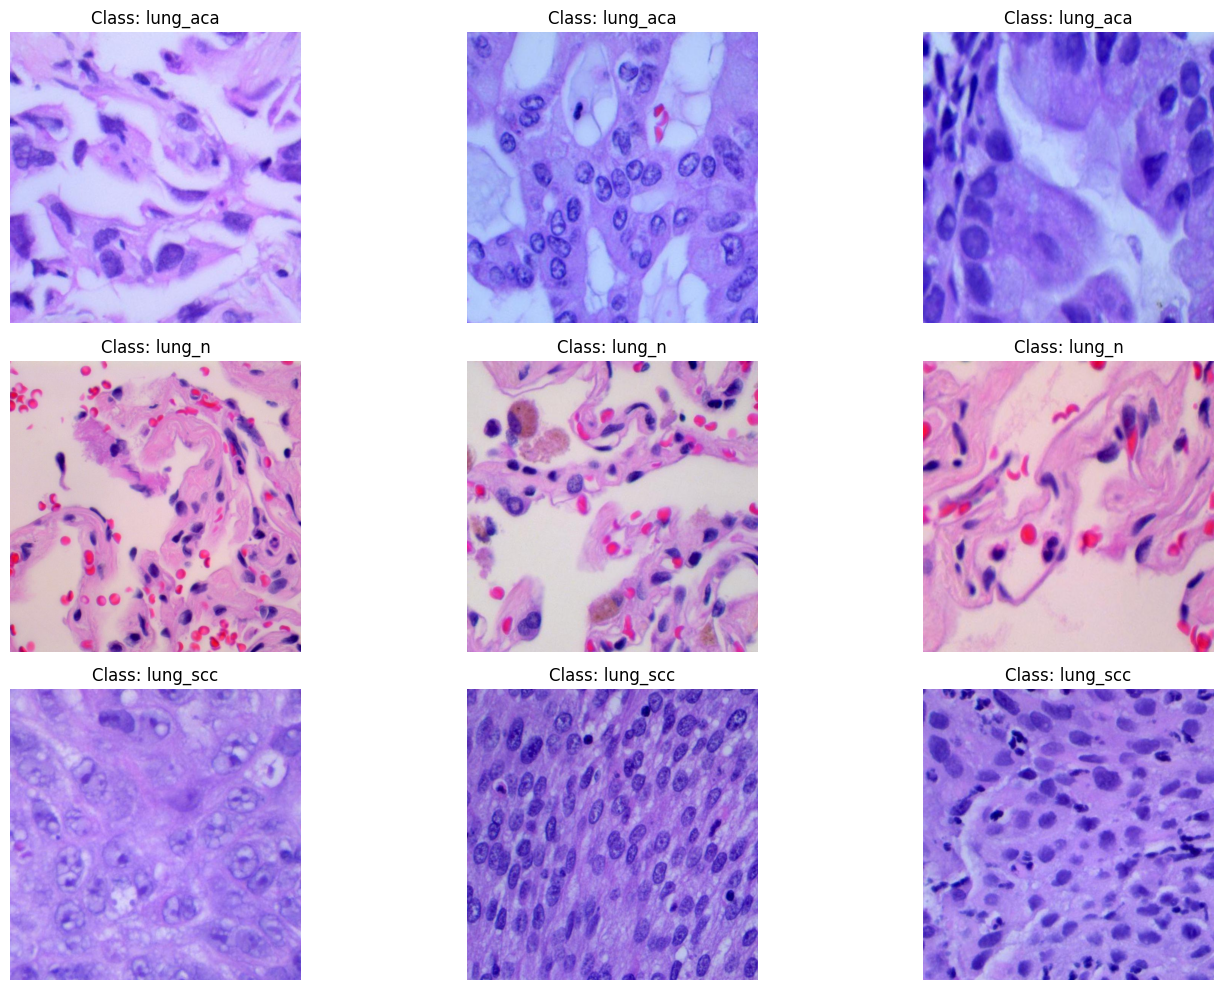

In [7]:
# Get unique class names
class_names = sorted(df['labels'].unique())
num_classes = len(class_names)

selected_classes = class_names[:3] 
num_images_per_class = 3  

plt.figure(figsize=(15, 10))

for idx, class_name in enumerate(selected_classes):
    class_df = df[df['labels'] == class_name]
    
    random_samples = class_df.sample(num_images_per_class)
    
    for i, (_, row) in enumerate(random_samples.iterrows()):
        image_path = row['filepaths']
        
        image = plt.imread(image_path)
        
        plt.subplot(3, len(selected_classes), idx * num_images_per_class + i + 1)
        plt.imshow(image)
        plt.title(f"Class: {class_name}")
        plt.axis("off")

plt.tight_layout()
plt.show()

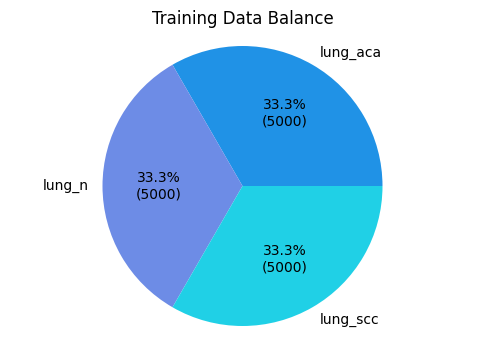

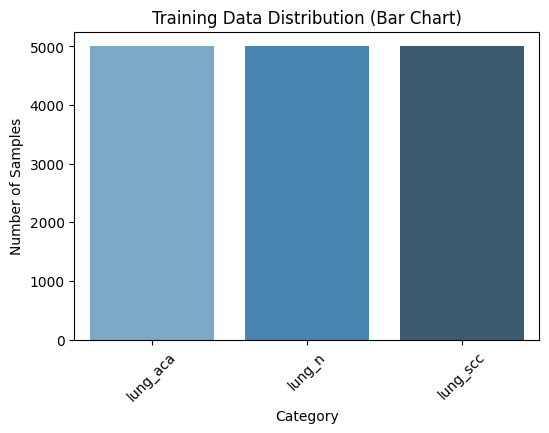

Statistical Summary of the Data Balance:
count       3.0
mean     5000.0
std         0.0
min      5000.0
25%      5000.0
50%      5000.0
75%      5000.0
max      5000.0
Name: count, dtype: float64


In [8]:
data_balance = df.labels.value_counts()

# Data Balance Pie Chart with enhanced details
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

# Pie Chart
plt.figure(figsize=(6, 4))
plt.pie(data_balance, labels=data_balance.index, autopct=custom_autopct, colors=["#2092E6", "#6D8CE6", "#20D0E6"])
plt.title("Training Data Balance")
plt.axis("equal")
plt.show()

# Bar Chart for Category Distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=data_balance.index, y=data_balance.values, palette="Blues_d")
plt.title("Training Data Distribution (Bar Chart)")
plt.xlabel("Category")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

# Additional Statistical Info (Number of categories, mean, median, etc.)
print("Statistical Summary of the Data Balance:")
print(data_balance.describe())

In [9]:
data_balance.index

Index(['lung_aca', 'lung_n', 'lung_scc'], dtype='object', name='labels')

## 4. Data Preprocessing and Splitting

##### Dataset Preparation
We will use the custom LungDataset class to wrap our DataFrame objects and prepare them for PyTorch models using DataLoader.

In [10]:
# Custom PyTorch Dataset class
class LungDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)  # reset index to ensure continuous indices
        self.transform = transform  # image transformations (e.g. resizing, normalization)
        self.label2idx = {label: idx for idx, label in enumerate(sorted(self.df['labels'].unique()))}
        
        print(f"Dataset loaded with {len(self.df)} samples.")

    def __len__(self):
        return len(self.df)  # total number of samples

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'filepaths']  # get image file path
        label = self.label2idx[self.df.loc[idx, 'labels']]  # convert label to index
        
        image = Image.open(image_path)  # open image
        if self.transform:
            image = self.transform(image)  # apply transformations (e.g. ToTensor)

        return image, label  # return transformed image and numeric label


##### Image Transforms
We use torchvision.transforms to resize, normalize, and convert images into PyTorch tensors.

In [11]:
IMG_SIZE = 224  # Define the image size for resizing
BATCH_SIZE = 128  # Define the batch size for DataLoader
MODEL_NAME = 'efficientnet_b3'  # Define the model name for transfer learning

In [12]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ])

In [ ]:
# Dataset Preparation
print("Splitting dataset into train, validation, and test sets...")
train_df, temp_df = train_test_split(df, train_size=0.8, random_state=42, shuffle=True)

# Validation seti oluşturmak için kalan veriyi bölelim
valid_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42, shuffle=True)

# Filter dataset for selected classes (isteğe bağlı, eğer sınıflar filtre edilecekse)
# train_df = train_df[train_df['labels'].isin(class_names)]
# valid_df = valid_df[valid_df['labels'].isin(class_names)]
# test_df = test_df[test_df['labels'].isin(class_names)]

# Dataset objects
transform = get_transforms()  # Veriyi ön işleme
train_dataset = LungDataset(train_df, transform)
valid_dataset = LungDataset(valid_df, transform)  # Validation seti için dataset
test_dataset = LungDataset(test_df, transform)

# DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Splitting and filtering dataset...
Dataset loaded with 12000 samples.
Dataset loaded with 3000 samples.


In [ ]:
print("Train DataFrame shape after filtering:", train_df.shape)
print("Test DataFrame shape after filtering:", test_df.shape)
print("Validation DataFrame shape after filtering:", valid_df.shape)

# Optionally, inspect class distributions too:
print("Train class distribution:\n", train_df['labels'].value_counts())
print("Validation class distribution:\n", valid_df['labels'].value_counts())
print("Test class distribution:\n", test_df['labels'].value_counts())

Train DataFrame shape after filtering: (12000, 2)
Test DataFrame shape after filtering: (3000, 2)
Train class distribution:
 labels
lung_n      4030
lung_scc    4007
lung_aca    3963
Name: count, dtype: int64
Test class distribution:
 labels
lung_aca    1037
lung_scc     993
lung_n       970
Name: count, dtype: int64


In [ ]:
# Define the EfficientNet model for feature extraction
print("Initializing EfficientNet model...")
# EfficientNet modelini yükle
efficientnet = timm.create_model('efficientnet_b3', pretrained=True)

# Son katmanı yeniden yapılandır
efficientnet.classifier = nn.Sequential(
    nn.Linear(efficientnet.classifier.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))  # Burada 'class_names' 3 sınıfı temsil ediyor
)

# 1. Tüm parametreleri dondur
for param in efficientnet.parameters():
    param.requires_grad = False

# 2. Son katmanı serbest bırak
for param in efficientnet.classifier.parameters():
    param.requires_grad = True
    
efficientnet = efficientnet.to(device) 


Initializing EfficientNet model...


In [16]:
def train_efficientnet(model, dataloaders, epochs=5, patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(dataloaders['train']):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(dataloaders['train'])
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss}, Accuracy: {100*correct/total}%")
        
        # Early stopping
        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            patience_counter = 0  # Reset counter if training loss improves
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# Run EfficientNet training
dataloaders = {'train': train_loader}  # Only using 'train_loader' now
train_efficientnet(efficientnet, dataloaders, epochs=15)

100%|██████████| 94/94 [01:20<00:00,  1.17it/s]


Epoch 1/15, Loss: 0.2201753945109692, Accuracy: 91.45%


100%|██████████| 94/94 [01:22<00:00,  1.15it/s]


Epoch 2/15, Loss: 0.11666425622682622, Accuracy: 95.24166666666666%


100%|██████████| 94/94 [01:19<00:00,  1.18it/s]


Epoch 3/15, Loss: 0.08889200219369316, Accuracy: 96.36666666666666%


100%|██████████| 94/94 [01:22<00:00,  1.14it/s]


Epoch 4/15, Loss: 0.07286735102930601, Accuracy: 97.35833333333333%


100%|██████████| 94/94 [01:19<00:00,  1.18it/s]


Epoch 5/15, Loss: 0.05919869662203053, Accuracy: 97.70833333333333%


100%|██████████| 94/94 [01:20<00:00,  1.17it/s]


Epoch 6/15, Loss: 0.053116775553752764, Accuracy: 97.88333333333334%


100%|██████████| 94/94 [01:21<00:00,  1.15it/s]


Epoch 7/15, Loss: 0.045451619999205814, Accuracy: 98.46666666666667%


100%|██████████| 94/94 [01:19<00:00,  1.18it/s]


Epoch 8/15, Loss: 0.03115317268059292, Accuracy: 98.90833333333333%


100%|██████████| 94/94 [01:15<00:00,  1.24it/s]


Epoch 9/15, Loss: 0.028016734154934577, Accuracy: 99.1%


100%|██████████| 94/94 [01:15<00:00,  1.24it/s]


Epoch 10/15, Loss: 0.024360025170298807, Accuracy: 99.15%


100%|██████████| 94/94 [01:19<00:00,  1.19it/s]


Epoch 11/15, Loss: 0.031622375542436666, Accuracy: 98.9%


100%|██████████| 94/94 [01:20<00:00,  1.17it/s]


Epoch 12/15, Loss: 0.016812199729177704, Accuracy: 99.43333333333334%


100%|██████████| 94/94 [01:22<00:00,  1.14it/s]


Epoch 13/15, Loss: 0.016227360251310104, Accuracy: 99.54166666666667%


100%|██████████| 94/94 [01:19<00:00,  1.19it/s]


Epoch 14/15, Loss: 0.014518129285127718, Accuracy: 99.50833333333334%


100%|██████████| 94/94 [01:20<00:00,  1.17it/s]

Epoch 15/15, Loss: 0.018831813722809263, Accuracy: 99.41666666666667%


In [17]:
def extract_features(model, dataloader):
    features = []
    labels = []
    model.eval()
    
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    
    with torch.no_grad():
        for inputs, labels_batch in tqdm(dataloader):
            inputs = inputs.to(device)
            outputs = feature_extractor(inputs)
            features.append(outputs.flatten(1).cpu().numpy())
            labels.append(labels_batch.cpu().numpy())
    
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [18]:
train_features, train_labels = extract_features(efficientnet, dataloaders['train'])

100%|██████████| 94/94 [01:18<00:00,  1.20it/s]
